## Data overview

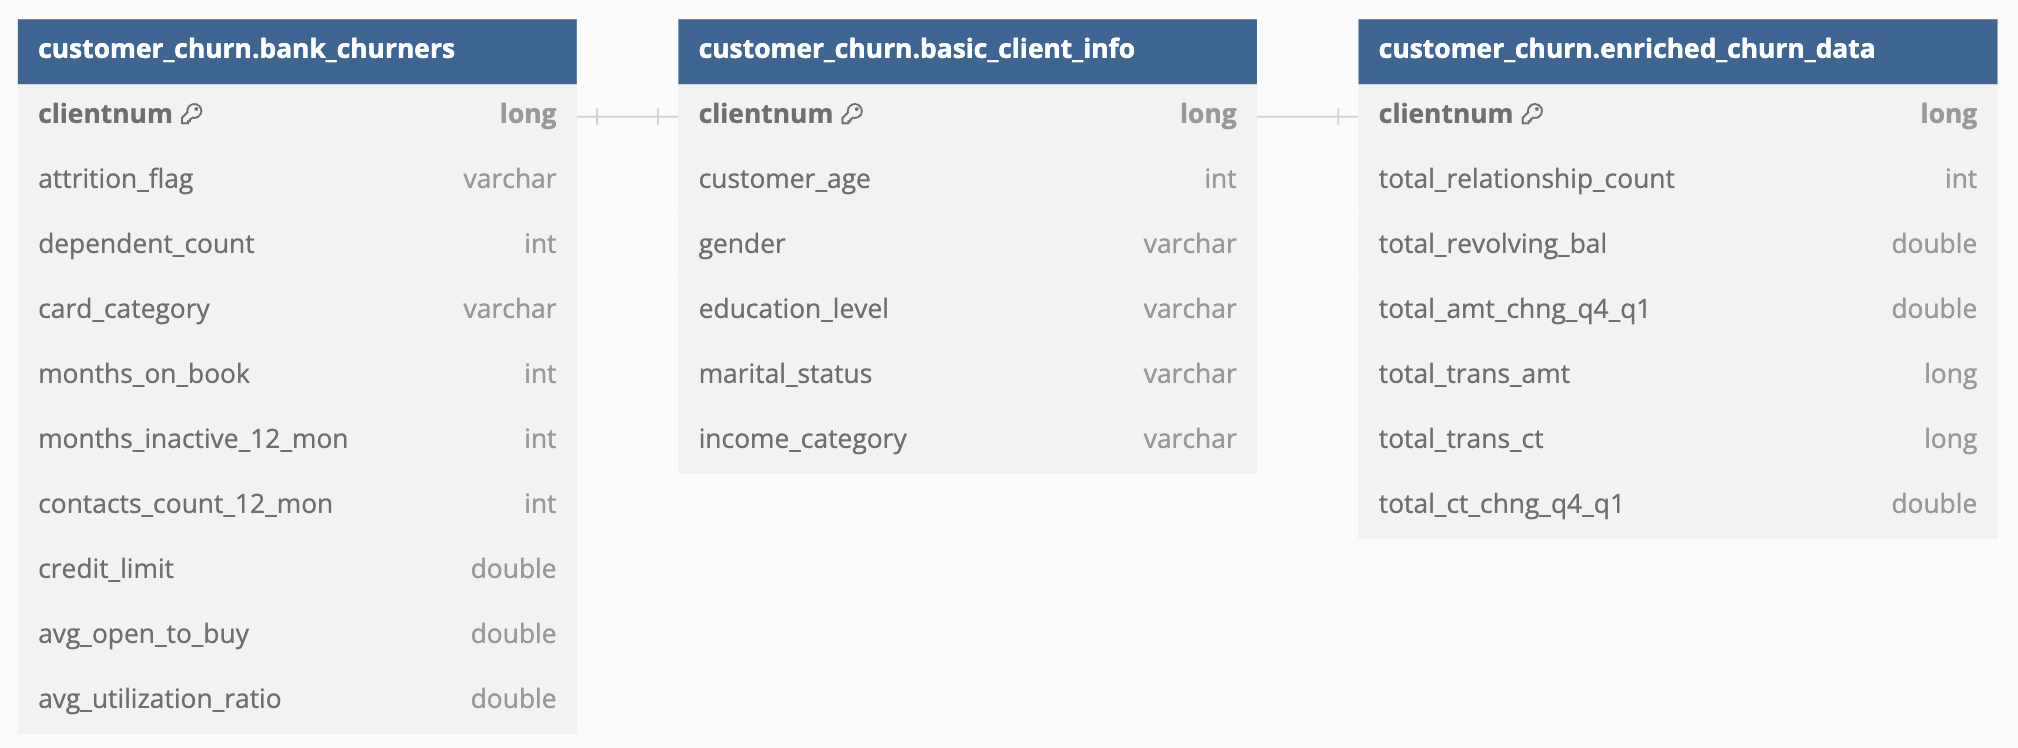

# Data Description
In this task, few datasets are provided:

1. **`BankChurners.csv`**   - this file contains basic information about each client (10 columns). The columns are:
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account;
    - `Attrition Flag` - Internal event (customer activity) variable - if the client had churned (attrited) or not (existing).
    - `Dependent Count` - Demographic variable - Number of dependents
    - `Card_Category` - Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
    - `Months_on_book` - Period of relationship with bank
    - `Months_Inactive_12_mon` - No. of months inactive in the last 12 months
    - `Contacts_Count_12_mon` - No. of Contacts in the last 12 months
    - `Credit_Limit` - Credit Limit on the Credit Card
    - `Avg_Open_To_Buy` - Open to Buy Credit Line (Average of last 12 months)
    - `Avg_Utilization_Ratio` - Average Card Utilization Ratio
2. **`basic_client_info.csv`** - this file contains some basic client info per each client (6 columns) -
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account
    - `Customer Age` - Demographic variable - Customer's Age in Years
    - `Gender` - Demographic variable - M=Male, F=Female
    - `Education_Level` - Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)`
    - `Marital_Status` - Demographic variable - Married, Single, Divorced, Unknown
    - `Income_Category` - Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown)
3. **`enriched_churn_data.csv`** - this file contains some enriched data about each client (7 columns) -
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account
    - `Total_Relationship_Count` - Total no. of products held by the customer
    - `Total_Revolving_Bal` - Total Revolving Balance on the Credit Card
    - `Total_Amt_Chng_Q4_Q1` - Change in Transaction Amount (Q4 over Q1)
    - `Total_Trans_Amt` - Total Transaction Amount (Last 12 months)
    - `Total_Trans_Ct` - Total Transaction Count (Last 12 months)
    - `Total_Ct_Chng_Q4_Q1` - Change in Transaction Count (Q4 over Q1)


In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
db_params = {
    'database': 'bank_info',
    'user': 'postgres',
    'password': 'beka',
    'host': 'localhost',
    'port': '5432',
}

connection_string = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"

engine = create_engine(connection_string)

def fetch_data_to_dataframe(engine, query):
    try:
        df = pd.read_sql_query(query, engine)

        return df

    except Exception as e:
        print(f"Unable to fetch data from the database. Error: {e}")
        return None

In [3]:
sql_query = 'SELECT * FROM bankchurners'
dataframe = fetch_data_to_dataframe(engine, sql_query)

In [4]:
dataframe.head()

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio
0,806160108,Existing Customer,1,Blue,56,2,3,3193,676,0.788
1,804424383,Existing Customer,1,Blue,56,3,2,10215,9205,0.099
2,708300483,Attrited Customer,0,Blue,56,4,3,7882,7277,0.077
3,808284783,Existing Customer,1,Blue,56,0,0,1438,1438,0.000
4,712720158,Existing Customer,1,Blue,56,2,3,13860,12208,0.119


## Chapter 1 SQL

1. How many clients does the bank have over the age of 50?

2. What is the distribution (in %) between men and women among clients?

3. Let's define a new variable called age_group (age group):

    10 < x ≤ 30

    30 < x ≤ 40

    40 < x ≤ 50

    50 < x ≤ 60

    60 < x ≤ 120

For each age group, marital status, and income category, find out the following values:

        a. Churn_rate (outflow coefficient, in %)

        b. Average number of Total_Relationship_Count (total number of relationships)

        c. Minimum value of Total_Amt_Chng_Q4_Q1 (change in the total amount from Q4 to Q1)

        d. Number of clients

Make sure that the data is ordered by the number of customers in descending order***

4. Among male clients who are holders of "blue" cards, how many (in %) fall into the income category of 40K - 60K?

5. Without using grouping, find the client IDs (CLIENTNUM's) with the third and fourth largest Total_Amt_Chng_Q4_Q1?

6. We are interested in which client (CLIENTNUM) has the second largest Total_Trans_Amt for each marital status.

###

### Solution of question 1

``` sql
SELECT count(*) FROM basic_client_info
WHERE customer_age > 50;
```

##### Answer: 3078

### Solution of question 2

``` sql
SELECT gender, COUNT(gender) AS total_count, round((COUNT(gender) * 100.0 / SUM(COUNT(*)) OVER ()), 2) AS percentage
FROM basic_client_info
GROUP BY gender;
```

##### Answer: M (males) - 47.09 %, F (females) - 52.91 %

### Solution of question 3
``` sql
-- 3.1 By age groups
WITH age_groups AS (
    SELECT
        CASE
            WHEN bc.customer_age BETWEEN 11 AND 30 THEN '11-30'
            WHEN bc.customer_age BETWEEN 31 AND 40 THEN '31-40'
            WHEN bc.customer_age BETWEEN 41 AND 50 THEN '41-50'
            WHEN bc.customer_age BETWEEN 51 AND 60 THEN '51-60'
            WHEN bc.customer_age BETWEEN 61 AND 120 THEN '61-120'
        END AS age_group,
        bk.attrition_flag,
        ec.total_relationship_count,
        ec.total_amt_chng_q4_q1
    FROM
        bankchurners bk
    JOIN
        basic_client_info bc ON bk.clientnum = bc.clientnum
    JOIN
        enriched_churn_data ec ON bc.clientnum = ec.clientnum
)
SELECT
    age_group,
    ROUND(SUM(CASE WHEN attrition_flag = 'Attrited Customer' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS churn_rate_percent,
    ROUND(AVG(total_relationship_count), 2) AS avg_total_relat_count,
    MIN(total_amt_chng_q4_q1) AS min_total_amt_q4_q1,
    COUNT(*) AS total_clients
FROM
    age_groups
GROUP BY
    age_group
ORDER BY
    total_clients;
```
![](screens/answer-3.1.png)

``` sql
-- 3.2 By marital status
SELECT
    bc.marital_status,
    ROUND(SUM(CASE WHEN bk.attrition_flag = 'Attrited Customer' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS churn_rate_percent,
    ROUND(AVG(ec.total_relationship_count), 2) AS avg_total_relat_count,
    MIN(ec.total_amt_chng_q4_q1) AS min_total_amt_q4_q1,
    COUNT(*) AS total_clients
FROM
    basic_client_info bc
JOIN bankchurners bk
    ON bc.clientnum = bk.clientnum
JOIN enriched_churn_data ec
    ON bc.clientnum = ec.clientnum
GROUP BY
    bc.marital_status
ORDER BY
    total_clients;
```
![](screens/answer-3.2.png)
``` sql
-- 3.3 By income category
SELECT
    bc.income_category,
    ROUND(SUM(CASE WHEN bk.attrition_flag = 'Attrited Customer' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS churn_rate_percent,
    ROUND(AVG(ec.total_relationship_count), 2) AS avg_total_relat_count,
    MIN(ec.total_amt_chng_q4_q1) AS min_total_amt_q4_q1,
    COUNT(*) AS total_clients
FROM
    basic_client_info bc
JOIN bankchurners bk
    ON bc.clientnum = bk.clientnum
JOIN enriched_churn_data ec
    ON bc.clientnum = ec.clientnum
GROUP BY
    bc.income_category
ORDER BY
    total_clients;
```
![](screens/answer-3.3.png)

###  Solution of question 4

``` sql
SELECT
    ROUND((COUNT(*) / (SELECT COUNT(*)::FLOAT
                       FROM basic_client_info bc
                       WHERE income_category = '$40K - $60K') * 100)::numeric, 2) AS percentage
FROM
    bankchurners bk
JOIN
    basic_client_info bc ON bk.clientnum = bc.clientnum
WHERE
    bc.gender = 'M' AND bk.card_category = 'Blue' AND bc.income_category = '$40K - $60K';
```

##### Answer: 39.94

###  Solution of question 5

``` sql
SELECT clientnum
FROM (
    SELECT
        clientnum,
        ROW_NUMBER() OVER (ORDER BY total_amt_chng_q4_q1 DESC) AS row_num
    FROM enriched_churn_data
) subquery
WHERE
    row_num IN (3, 4);
```

##### Answer: clientnum - 713989233, clientnum - 713982108

###  Solution of question 6
``` sql
WITH clientnum_2_total_trans_amt AS (
    SELECT
        ecd.clientnum,
        ecd.total_trans_amt as total_trans_amt_2,
        bci.marital_status,
        ROW_NUMBER() OVER (PARTITION BY marital_status ORDER BY total_trans_amt DESC) AS row_num
    FROM enriched_churn_data ecd
    JOIN basic_client_info bci ON ecd.clientnum = bci.clientnum
)
SELECT
    clientnum,
    total_trans_amt_2,
    marital_status
FROM clientnum_2_total_trans_amt
WHERE row_num = 2;
```
![](screens/answer-6.png)

## Part 2: Exploring the data

Go through each one

1. Check each of the three tables presented for emissions (you can look at 1.5*IQR)
2. Look at the distribution of values in each of the columns of the three tables (in seaborn you can easily do this)
3. Combine all three tables
4. Build a correlation matrix and visualize it
- Identify issues here that can potentially be investigated (read more below)

For example, you should get a graph like this (matplotlib + seaborn):

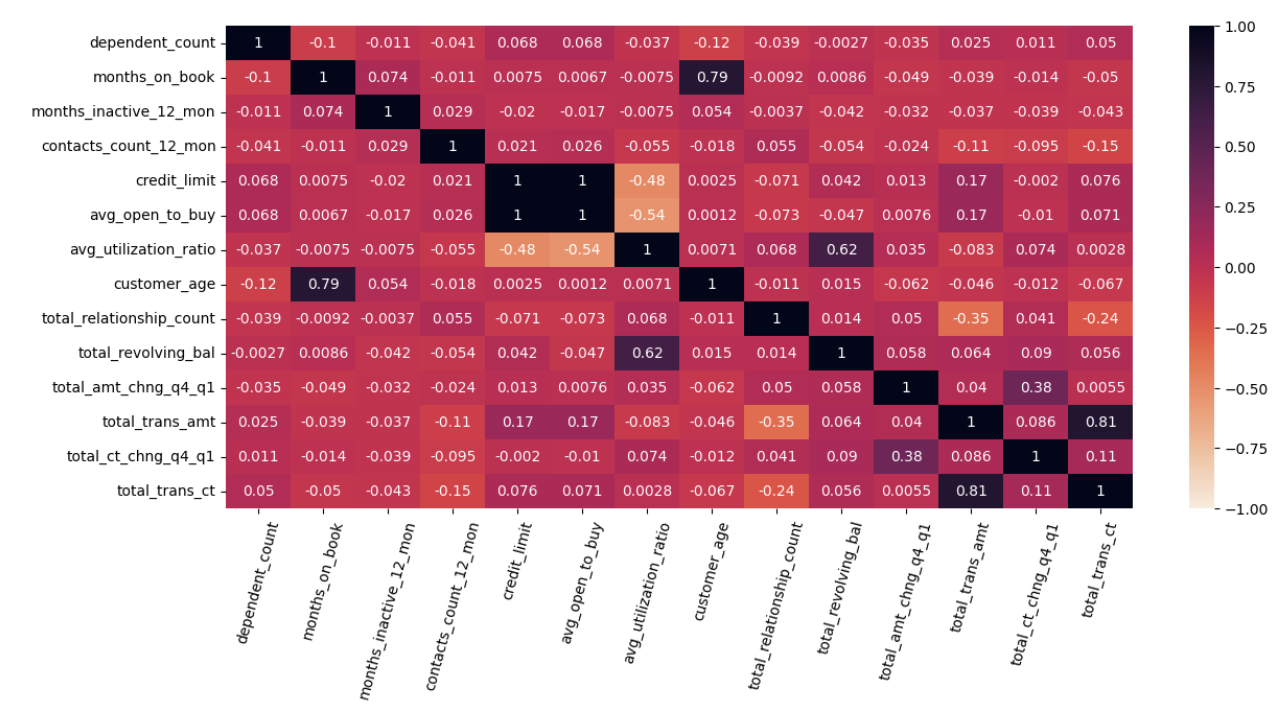


And then, based on this graph, try to formulate your questions and get an answer to them. I suggest answering the questions presented, but also **be sure** to add to this list **+1** an interesting question, the answer to which you will need to determine from the data 


- How long have customers of different ages been using the bank's credit card, and what is the relationship between age and the number of months of using the service?
- What is the relationship between the customer's credit limit or the average available loan and the average utilization rate over the past 12 months?
- How does the amount of transactions change depending on the number of products that customers use?

### Solution of question 1

In [5]:
# Emissions bankchurners

sql_query = 'SELECT * FROM bankchurners'
dataframe = fetch_data_to_dataframe(engine, sql_query)
Q1 = dataframe['clientnum'].quantile(0.25)
Q3 = dataframe['clientnum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding emissions
outliers = dataframe[(dataframe['clientnum'] < lower_bound) | (dataframe['clientnum'] > upper_bound)]
print("Emissions:")
print(outliers)

Emissions:
Empty DataFrame
Columns: [clientnum, attrition_flag, dependent_count, card_category, months_on_book, months_inactive_12_mon, contacts_count_12_mon, credit_limit, avg_open_to_buy, avg_utilization_ratio]
Index: []


In [6]:
# Emissions basic_client_info

sql_query = 'SELECT * FROM basic_client_info'
dataframe = fetch_data_to_dataframe(engine, sql_query)
Q1 = dataframe['clientnum'].quantile(0.25)
Q3 = dataframe['clientnum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding emissions
outliers = dataframe[(dataframe['clientnum'] < lower_bound) | (dataframe['clientnum'] > upper_bound)]
print("Выбросы:")
print(outliers)

Выбросы:
Empty DataFrame
Columns: [clientnum, customer_age, gender, education_level, marital_status, income_category]
Index: []


In [7]:
# Emissions enriched_churn_data
sql_query = 'SELECT * FROM enriched_churn_data'
dataframe = fetch_data_to_dataframe(engine, sql_query)
Q1 = dataframe['clientnum'].quantile(0.25)
Q3 = dataframe['clientnum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding emissions
outliers = dataframe[(dataframe['clientnum'] < lower_bound) | (dataframe['clientnum'] > upper_bound)]
print("Выбросы:")
print(outliers)

Выбросы:
Empty DataFrame
Columns: [clientnum, total_relationship_count, total_revolving_bal, total_amt_chng_q4_q1, total_trans_amt, total_ct_chng_q4_q1, total_trans_ct]
Index: []


### Solution of question 2

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
sql_query = '''SELECT attrition_flag,dependent_count, card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio 
               FROM bankchurners'''
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe.head()

,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio
0,Existing Customer,1,Blue,56,2,3,3193,676,0.788
1,Existing Customer,1,Blue,56,3,2,10215,9205,0.099
2,Attrited Customer,0,Blue,56,4,3,7882,7277,0.077
3,Existing Customer,1,Blue,56,0,0,1438,1438,0.000
4,Existing Customer,1,Blue,56,2,3,13860,12208,0.119


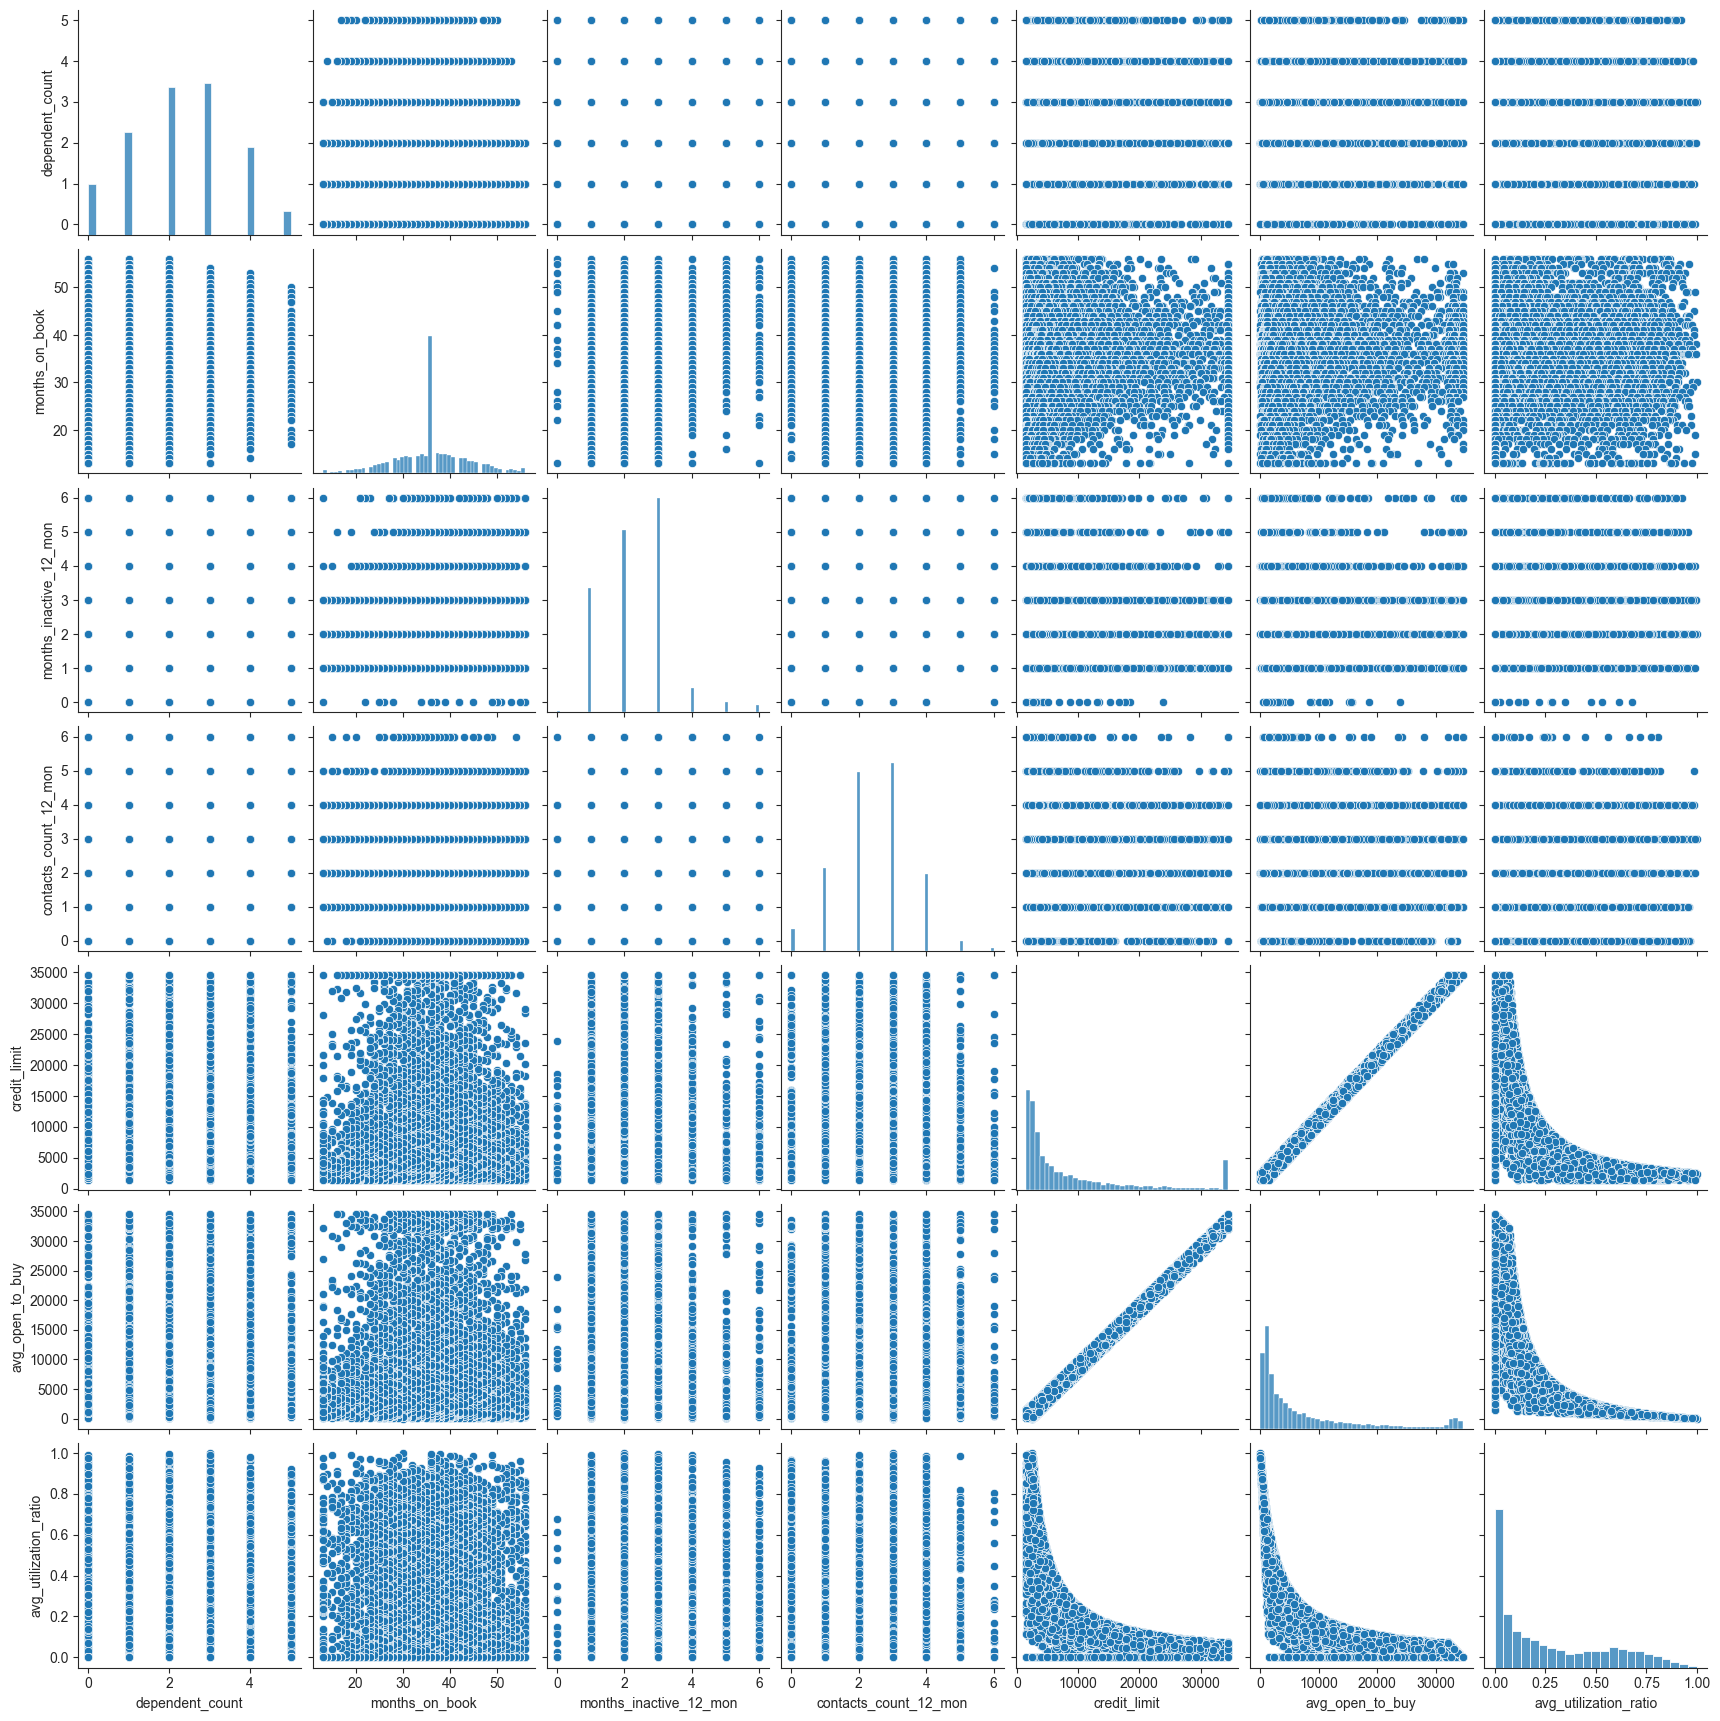

In [10]:
sns.set_style('ticks')
sns.pairplot(dataframe)
plt.show()

/var/folders/9p/2b9k_p8n1_xcx6qqb22xgw780000gn/T/ipykernel_5012/2761793228.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataframe, x='card_category', palette='coolwarm')


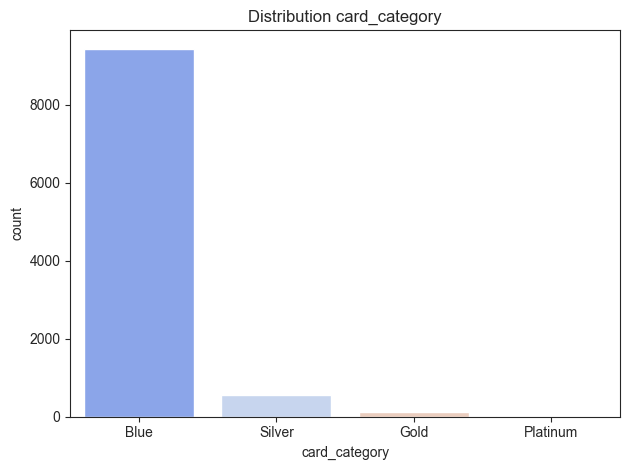

In [11]:
sns.countplot(data=dataframe, x='card_category', palette='coolwarm')
plt.title('Distribution card_category')

plt.tight_layout()
plt.show()

In [12]:
sql_query = 'SELECT customer_age, gender, education_level,marital_status, income_category FROM basic_client_info'
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe.head()

,customer_age,gender,education_level,marital_status,income_category
0,45,F,High School,Married,Less than $40K
1,58,M,Unknown,Single,$40K - $60K
2,46,M,Doctorate,Divorced,$80K - $120K
3,34,F,Uneducated,Single,Less than $40K
4,49,F,Uneducated,Married,Unknown


/var/folders/9p/2b9k_p8n1_xcx6qqb22xgw780000gn/T/ipykernel_5012/1273148193.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataframe, x=column, ax=axes[row, col], palette='deep')
/var/folders/9p/2b9k_p8n1_xcx6qqb22xgw780000gn/T/ipykernel_5012/1273148193.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataframe, x=column, ax=axes[row, col], palette='deep')
/var/folders/9p/2b9k_p8n1_xcx6qqb22xgw780000gn/T/ipykernel_5012/1273148193.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataframe, x=column, ax=axes[row,

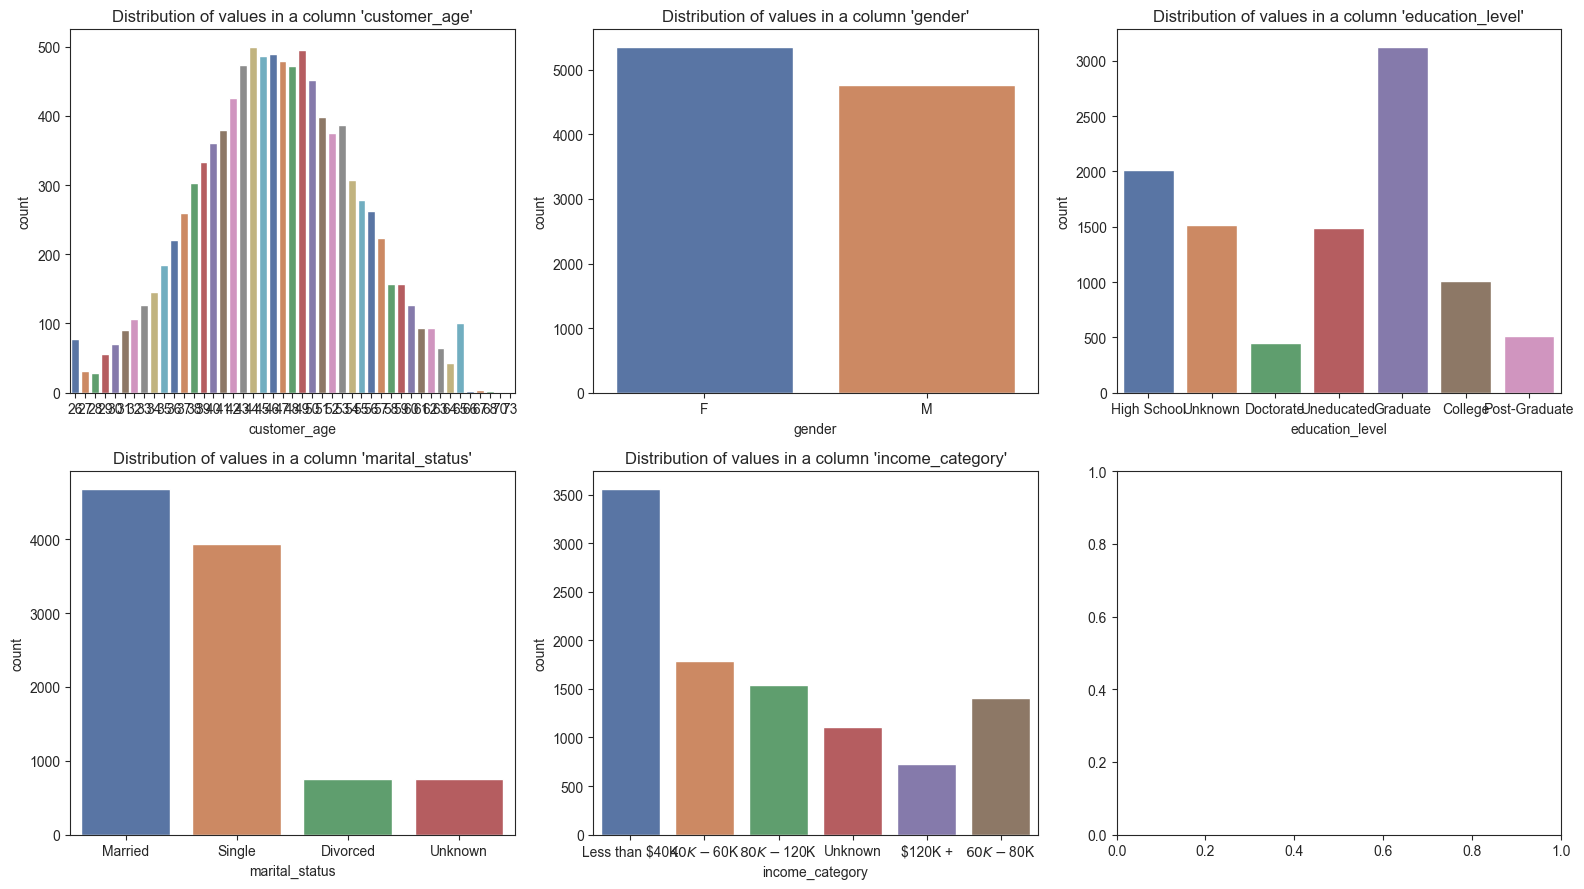

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))

for i, column in enumerate(dataframe.columns):
    row = i // 3  
    col = i % 3  
    sns.countplot(data=dataframe, x=column, ax=axes[row, col], palette='deep')
    axes[row, col].set_title(f"Distribution of values in a column '{column}'")

plt.tight_layout()
plt.show()


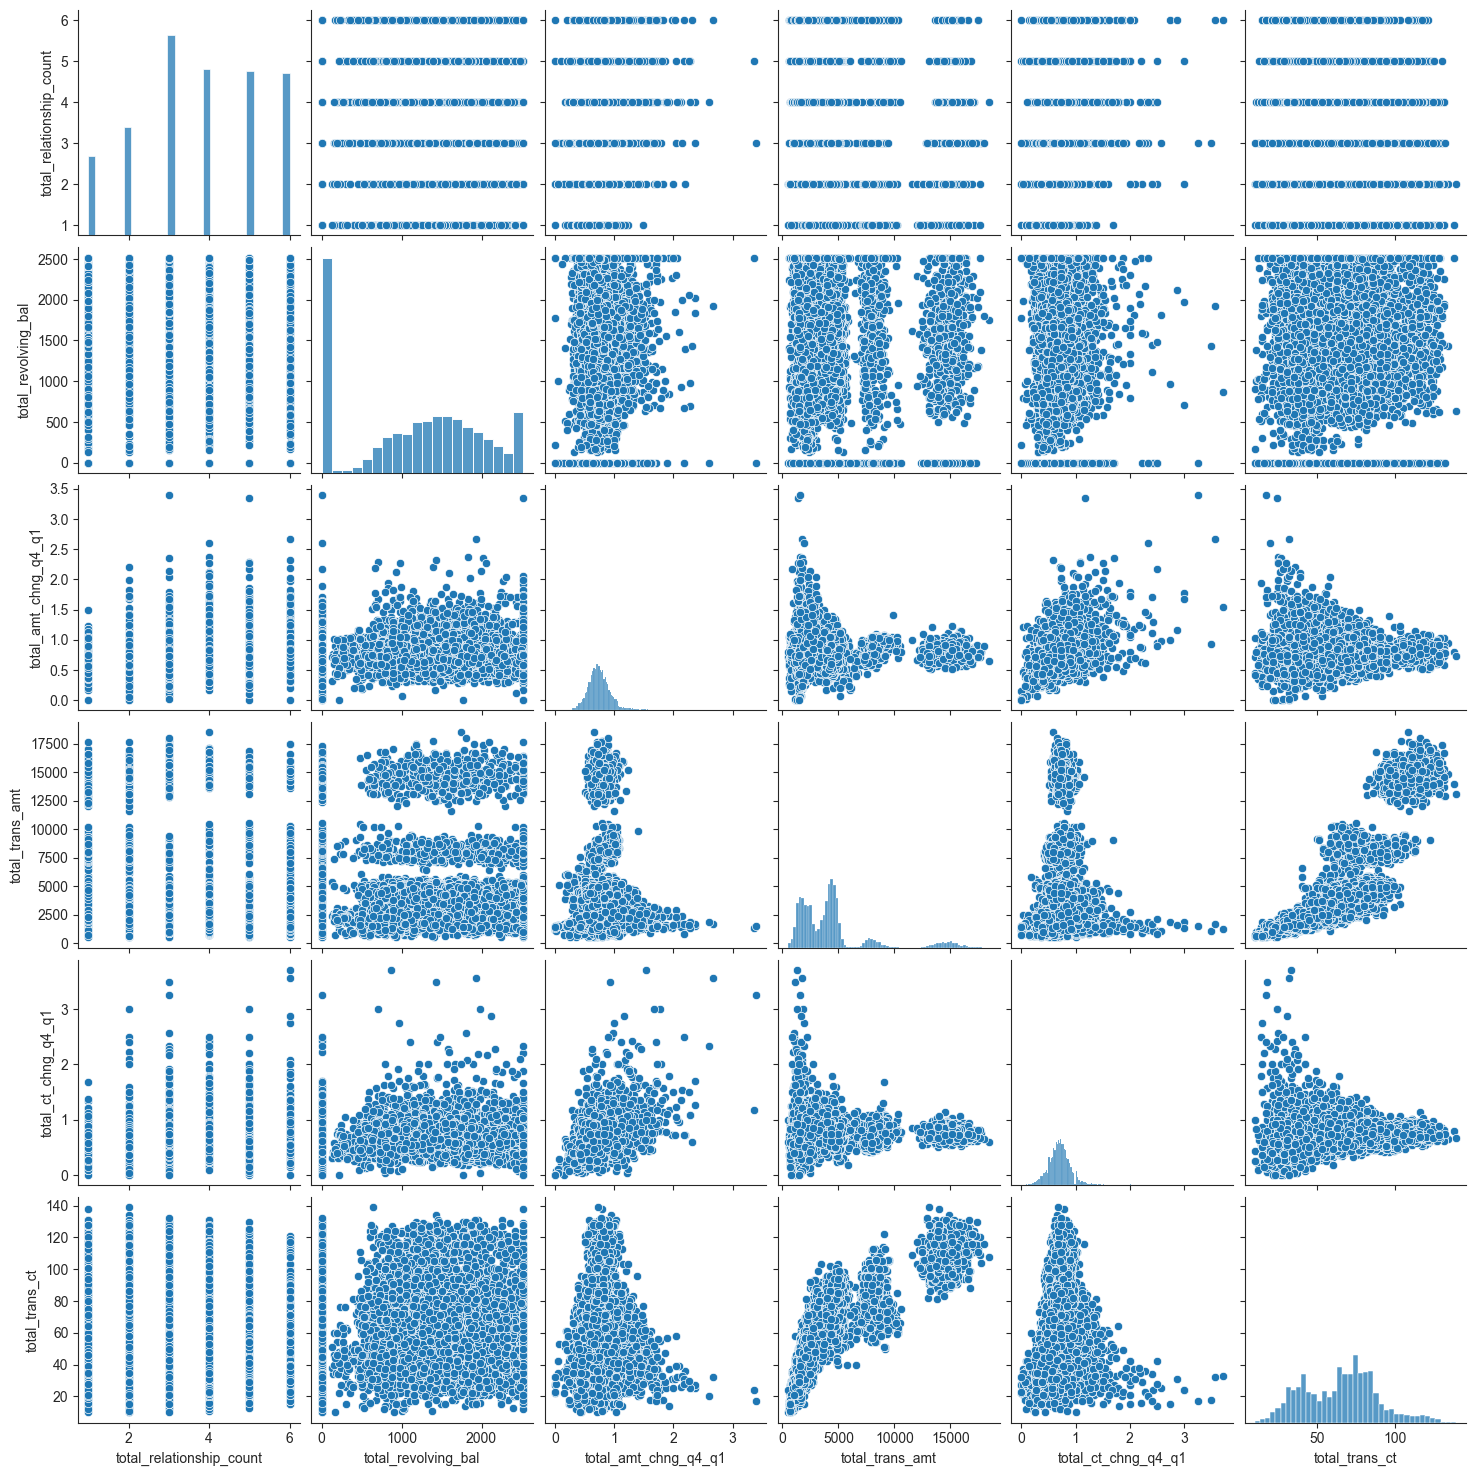

In [14]:
sql_query = 'SELECT total_relationship_count, total_revolving_bal, total_amt_chng_q4_q1, total_trans_amt, total_ct_chng_q4_q1, total_trans_ct FROM enriched_churn_data'
dataframe = fetch_data_to_dataframe(engine, sql_query)
sns.set_style('ticks')
sns.pairplot(dataframe)
plt.show()

### Solution of question 3

In [15]:
sql_query = 'SELECT * FROM bankchurners bk JOIN basic_client_info bci USING (clientnum) JOIN enriched_churn_data ecd USING (clientnum)'
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe.head()

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,...,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct
0,806160108,Existing Customer,1,Blue,56,2,3,3193,676,0.788,...,M,High School,Married,$40K - $60K,2,2517,1.831,1336,1.143,30
1,804424383,Existing Customer,1,Blue,56,3,2,10215,9205,0.099,...,M,Unknown,Married,$60K - $80K,3,1010,0.843,1904,1.000,40
2,708300483,Attrited Customer,0,Blue,56,4,3,7882,7277,0.077,...,F,Doctorate,Married,Unknown,5,605,1.052,704,0.143,16
3,808284783,Existing Customer,1,Blue,56,0,0,1438,1438,0.000,...,F,Unknown,Married,Less than $40K,6,0,0.813,1951,1.095,44
4,712720158,Existing Customer,1,Blue,56,2,3,13860,12208,0.119,...,M,Graduate,Married,Unknown,5,1652,1.255,1910,1.909,32


### Solution of question 4

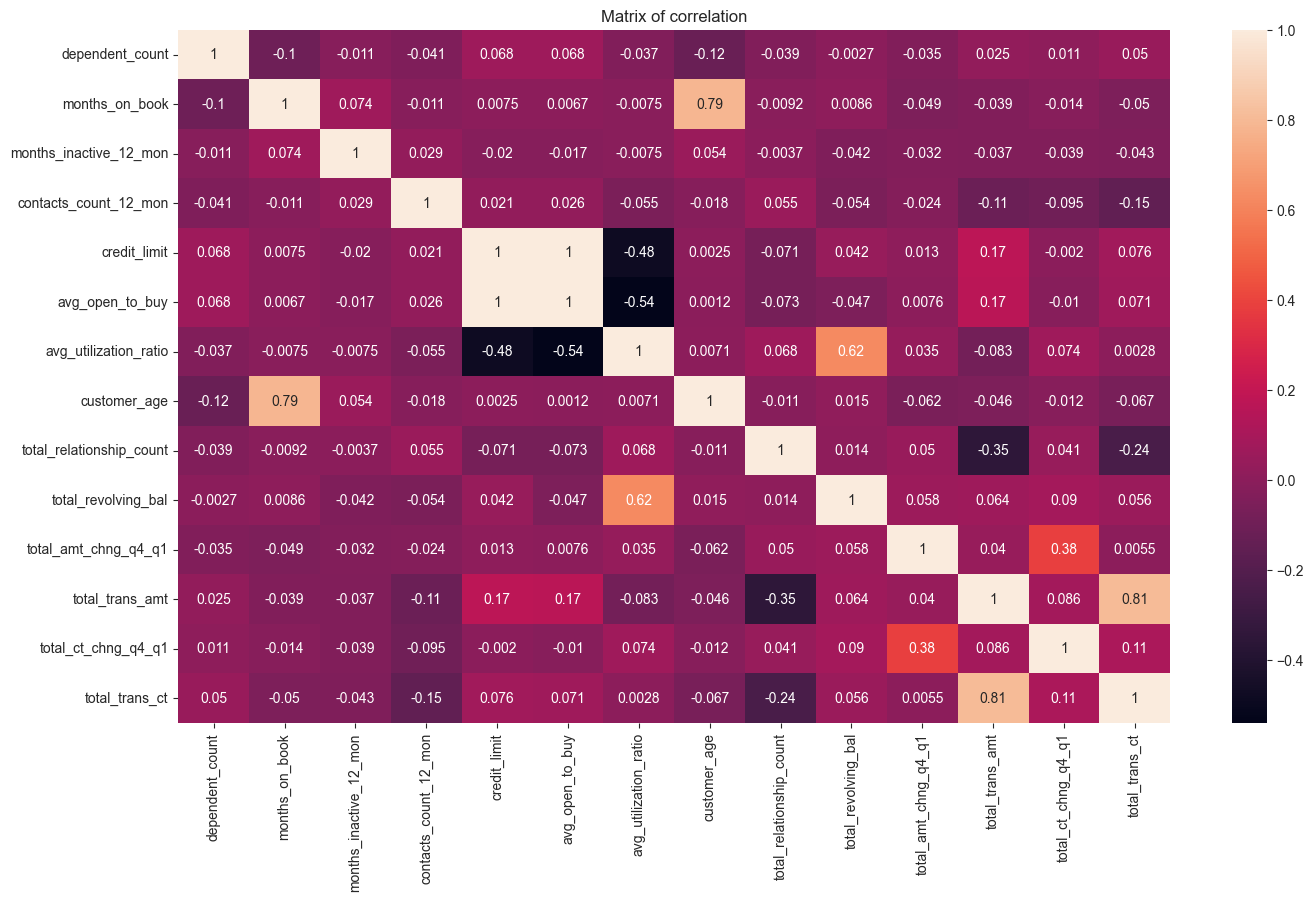

In [16]:
df = dataframe.select_dtypes(include='number')
df = df.drop(columns=['clientnum'])
correlation_matrix = df.corr()

plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matrix of correlation')
plt.show()

### Solution of quesiton 4.1

In [17]:
sql_query = """WITH age_groups AS (
    SELECT
        CASE
            WHEN bci.customer_age BETWEEN 11 AND 30 THEN '11-30'
            WHEN bci.customer_age BETWEEN 31 AND 40 THEN '31-40'
            WHEN bci.customer_age BETWEEN 41 AND 50 THEN '41-50'
            WHEN bci.customer_age BETWEEN 51 AND 60 THEN '51-60'
            WHEN bci.customer_age BETWEEN 61 AND 120 THEN '61-120'
            ELSE 'Others'  -- Define an 'Others' category for age groups outside of these ranges if needed
        END AS age_group,
        bk.months_on_book
    FROM
        bankchurners bk
    JOIN
        basic_client_info bci ON bk.clientnum = bci.clientnum
)
SELECT
    age_group,
    ROUND(AVG(months_on_book), 2) AS avg_month_using
FROM
    age_groups
GROUP BY
    age_group
ORDER BY
    age_group;"""
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe

,age_group,avg_month_using
0,11-30,21.95
1,31-40,28.37
2,41-50,35.36
3,51-60,42.29
4,61-120,49.48


/var/folders/9p/2b9k_p8n1_xcx6qqb22xgw780000gn/T/ipykernel_5012/1132815080.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='avg_month_using', data=dataframe, palette='viridis')


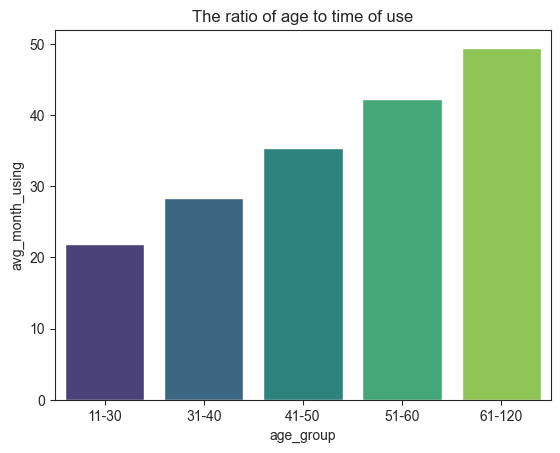

In [18]:
sns.barplot(x='age_group', y='avg_month_using', data=dataframe, palette='viridis')
plt.xlabel('age_group')
plt.ylabel('avg_month_using')
plt.title('The ratio of age to time of use')
plt.show()

### Solution of question 4.2

In [19]:
sql_query = "select bankchurners.credit_limit, bankchurners.avg_utilization_ratio from bankchurners"
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe.head()

,credit_limit,avg_utilization_ratio
0,3193,0.788
1,10215,0.099
2,7882,0.077
3,1438,0.000
4,13860,0.119


![](screens/chart-4.2.png)

##### There is a slight relationship between the credit limit and the average usage ratio. It can be said that the lower the credit limit, the higher the utilization factor.

### Solution of question 4.3

In [20]:
sql_query = """select ecd.total_relationship_count, round(avg(ecd.total_trans_amt), 2) as avg_total_trans_amt
from enriched_churn_data ecd
group by ecd.total_relationship_count
order by ecd.total_relationship_count"""
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe

,total_relationship_count,avg_total_trans_amt
0,1,7252.92
1,2,7019.15
2,3,3936.28
3,4,3754.97
4,5,3515.33
5,6,3416.45


/var/folders/9p/2b9k_p8n1_xcx6qqb22xgw780000gn/T/ipykernel_5012/3610294953.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_relationship_count', y='avg_total_trans_amt', data=dataframe, palette='muted')


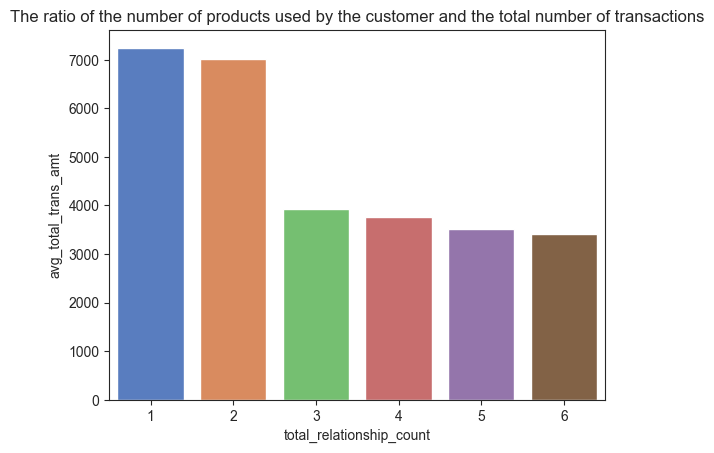

In [21]:
sns.barplot(x='total_relationship_count', y='avg_total_trans_amt', data=dataframe, palette='muted')
plt.xlabel('total_relationship_count')
plt.ylabel('avg_total_trans_amt')
plt.title('The ratio of the number of products used by the customer and the total number of transactions')
plt.show()

### How does the client's level of education affect the total working balance on the card?

In [22]:
sql_query = """select education_level, round(avg(total_revolving_bal), 2) as avg_total_revol_bal
from basic_client_info bci
join enriched_churn_data ecd
on bci.clientnum = ecd.clientnum
group by education_level
order by avg_total_revol_bal"""
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe

,education_level,avg_total_revol_bal
0,Doctorate,1094.08
1,College,1135.78
2,Uneducated,1154.08
3,Unknown,1160.45
4,Graduate,1162.38
5,Post-Graduate,1187.67
6,High School,1194.35


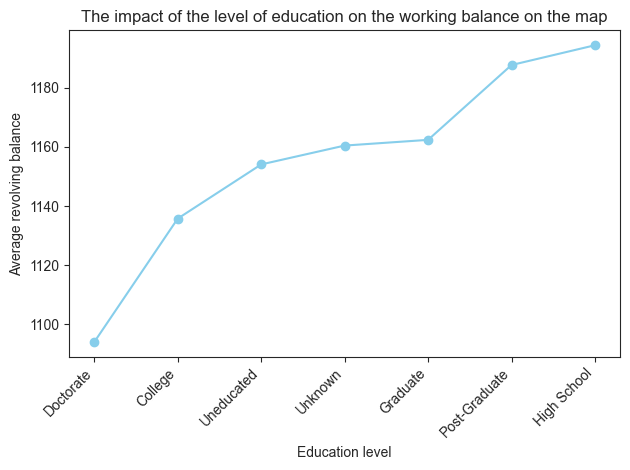

In [23]:
plt.plot(dataframe['education_level'], dataframe['avg_total_revol_bal'], marker='o', color='skyblue',)
plt.xlabel('Education level')
plt.ylabel('Average revolving balance')
plt.title('The impact of the level of education on the working balance on the map')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Part 3: Substantive issues

Here you should focus on interpretation!!!

Try to creatively choose another question

1. Which credit card holders leave most often (churn/attrition)? What is the situation with customer retention?
2. Is there a relationship between the credit card category, income category and the use of credit cards by customers?
3. How does the income category and number of dependents per customer affect their credit card needs or usage?
4. Which age groups use their credit cards the most and least actively? And which age groups have the largest number of departed clients?


####

### Solution of question 1

``` sql
SELECT bankchurners.card_category,
       ROUND(SUM(CASE WHEN bankchurners.attrition_flag = 'Attrited Customer' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS percent_attrition_customers,
       ROUND(SUM(CASE WHEN bankchurners.attrition_flag = 'Existing Customer' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS percent_retention_customers
FROM bankchurners
GROUP BY card_category
ORDER BY percent_attrition_customers DESC;
```
![](screens/3-part.2.png)

### Solution of question 2

In [24]:
sql_query = 'select bk.card_category, bci.income_category, bk.avg_utilization_ratio from bankchurners bk join basic_client_info bci on bk.clientnum = bci.clientnum'
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe.head()

,card_category,income_category,avg_utilization_ratio
0,Blue,$40K - $60K,0.788
1,Blue,$60K - $80K,0.099
2,Blue,Unknown,0.077
3,Blue,Less than $40K,0.000
4,Blue,Unknown,0.119


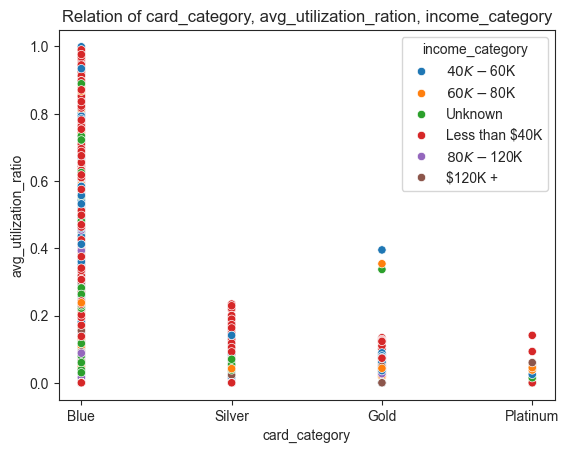

In [25]:
sns.scatterplot(x='card_category', y='avg_utilization_ratio', hue='income_category', data=dataframe)
plt.xlabel('card_category')
plt.ylabel('avg_utilization_ratio')
plt.title('Relation of card_category, avg_utilization_ration, income_category')
plt.show()

##### According to the graph, it can be said that customers with a blue card use their card more often, and customers with a platinum card, on the contrary, less often. It can also be said that customers with an income of less than $40k use their card more than customers with a different income category.

### Solution of question 3

In [26]:
sql_query = 'select bci.income_category, sum(bk.dependent_count) as total_num_dependences, round(avg(bk.avg_utilization_ratio::numeric), 2) as avg_util from basic_client_info bci join bankchurners bk on bci.clientnum = bk.clientnum group by bci.income_category order by bci.income_category'
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe.head()

,income_category,total_num_dependences,avg_util
0,$120K +,1790,0.13
1,$40K - $60K,4132,0.32
2,$60K - $80K,3421,0.21
3,$80K - $120K,3826,0.16
4,Less than $40K,8061,0.38


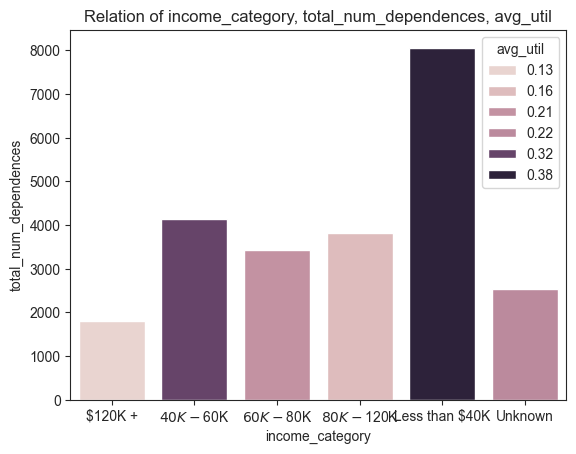

In [27]:
sns.barplot(x='income_category', y='total_num_dependences', hue='avg_util', data=dataframe)
plt.xlabel('income_category')
plt.ylabel('total_num_dependences')
plt.title('Relation of income_category, total_num_dependences, avg_util')
plt.show()

##### According to the graph, it can be said that customers with an income of less than $40K have the most dependents, and it is also clearly visible that they use the card most often.

### Solution of question 4

In [28]:
sql_query = """WITH age_groups AS (
    SELECT
        CASE
            WHEN bci.customer_age BETWEEN 11 AND 30 THEN '11-30'
            WHEN bci.customer_age BETWEEN 31 AND 40 THEN '31-40'
            WHEN bci.customer_age BETWEEN 41 AND 50 THEN '41-50'
            WHEN bci.customer_age BETWEEN 51 AND 60 THEN '51-60'
            WHEN bci.customer_age BETWEEN 61 AND 120 THEN '61-120'
            ELSE 'Others'  -- Define an 'Others' category for age groups outside of these ranges if needed
        END AS age_group,
        bk.avg_utilization_ratio,
        bk.attrition_flag
    FROM
        bankchurners bk
    JOIN
        basic_client_info bci ON bk.clientnum = bci.clientnum
)
SELECT
    age_group,
    SUM(avg_utilization_ratio) AS total_avg_utilization,
    SUM(CASE WHEN attrition_flag = 'Attrited Customer' THEN 1 ELSE 0 END) AS attrition_num
FROM
    age_groups
GROUP BY
    age_group"""

dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe.head()

,age_group,total_avg_utilization,attrition_num
0,11-30,81.58998,32
1,51-60,772.19385,448
2,61-120,124.14102,58
3,31-40,615.56030,310
4,41-50,1190.36070,779


In [29]:
df_sorted = dataframe.sort_values('total_avg_utilization', ascending=False)
df_sorted

,age_group,total_avg_utilization,attrition_num
4,41-50,1190.36070,779
1,51-60,772.19385,448
3,31-40,615.56030,310
2,61-120,124.14102,58
0,11-30,81.58998,32


##### According to these data, we see that the age group from 41 to 50 years used the bank the most, and customers aged 11 to 30 years used the bank's services the least.

In [30]:
df_sorted = dataframe.sort_values('attrition_num', ascending=False)
df_sorted

,age_group,total_avg_utilization,attrition_num
4,41-50,1190.36070,779
1,51-60,772.19385,448
3,31-40,615.56030,310
2,61-120,124.14102,58
0,11-30,81.58998,32


##### Customers aged 41 to 50 left the bank the most.

#### ML model using Random Forest to identify the most significant variables for the churn rate

In [31]:
sql_query = "SELECT * FROM bankchurners bk JOIN basic_client_info bci USING (clientnum) JOIN enriched_churn_data ecd USING (clientnum)"
dataframe = fetch_data_to_dataframe(engine, sql_query)
dataframe.head()

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,...,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct
0,806160108,Existing Customer,1,Blue,56,2,3,3193,676,0.788,...,M,High School,Married,$40K - $60K,2,2517,1.831,1336,1.143,30
1,804424383,Existing Customer,1,Blue,56,3,2,10215,9205,0.099,...,M,Unknown,Married,$60K - $80K,3,1010,0.843,1904,1.000,40
2,708300483,Attrited Customer,0,Blue,56,4,3,7882,7277,0.077,...,F,Doctorate,Married,Unknown,5,605,1.052,704,0.143,16
3,808284783,Existing Customer,1,Blue,56,0,0,1438,1438,0.000,...,F,Unknown,Married,Less than $40K,6,0,0.813,1951,1.095,44
4,712720158,Existing Customer,1,Blue,56,2,3,13860,12208,0.119,...,M,Graduate,Married,Unknown,5,1652,1.255,1910,1.909,32


In [32]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
le = LabelEncoder()

In [33]:
le_count = 0
for col in dataframe.columns[1:]:
    if dataframe[col].dtype == 'object':
        if len(list(dataframe[col].unique())) <= 2:
            le.fit(dataframe[col])
            dataframe[col] = le.transform(dataframe[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

2 columns were label encoded.


In [34]:
dataframe = pd.get_dummies(dataframe, drop_first=False)

In [35]:
scaler = MinMaxScaler(feature_range=(0, 5))
df_col = list(dataframe.columns)
df_col.remove('attrition_flag')
for col in df_col:
    dataframe[col] = dataframe[col].astype(float)
    dataframe[col] = scaler.fit_transform(dataframe[[col]])
dataframe['attrition_flag'] = pd.to_numeric(dataframe['attrition_flag'], downcast='float')
dataframe = dataframe.drop('clientnum', axis=1)
dataframe.head()

,attrition_flag,dependent_count,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,gender,...,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,income_category_$120K +,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,income_category_Unknown
0,1.0,1.0,5.0,1.666667,2.500000,0.265282,0.097499,3.943944,3.723404,5.0,...,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1,1.0,1.0,5.0,2.500000,1.666667,1.326713,1.333121,0.495495,3.936170,5.0,...,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
2,0.0,0.0,5.0,3.333333,2.500000,0.974061,1.053806,0.385385,4.255319,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,1.0,1.0,5.0,0.000000,0.000000,0.000000,0.207893,0.000000,3.829787,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,1.0,1.0,5.0,1.666667,2.500000,1.877683,1.768174,0.595596,4.468085,5.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
X = dataframe.drop('attrition_flag', axis=1)
y = dataframe['attrition_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
feature_importances = model.feature_importances_

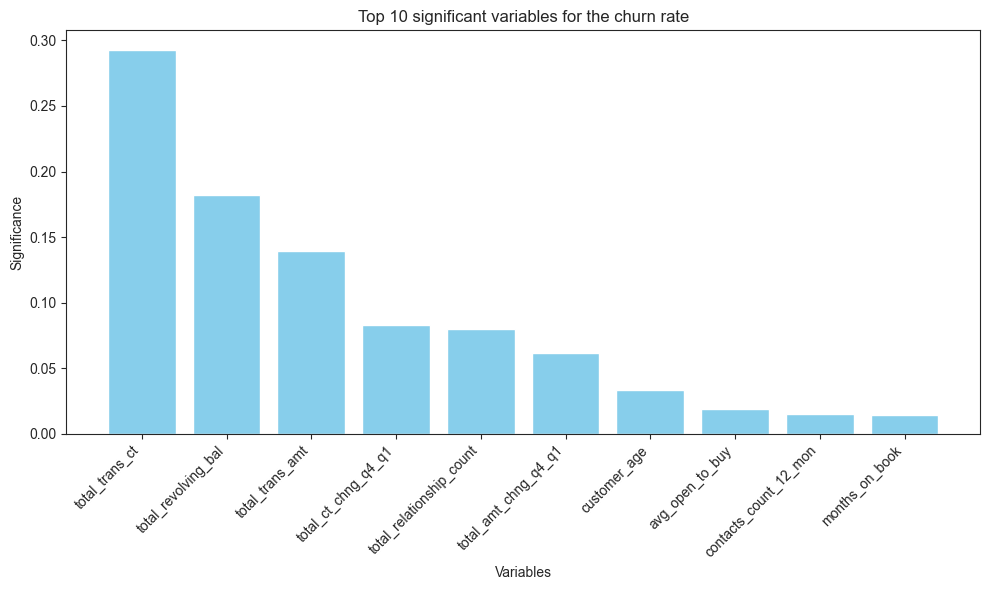

In [38]:
# Creating a Data Frame to display the significance of features
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_10_feature_importance_df = feature_importance_df[:10]

plt.figure(figsize=(10, 6))
plt.bar(top_10_feature_importance_df['Feature'], top_10_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Variables')
plt.ylabel('Significance')
plt.title('Top 10 significant variables for the churn rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()